3)Text Classification by fine-tuning LLM model

Plot the two learning curves - training and validation (i.e., x-axis: number of epochs; y-axis: losses) for 5 epochs. (1 point)
Using the approach to compute accuracy (i.e., all labels must match) in the tutorial, what is the test accuracy? (0.5 points)
Modify the accuracy such that a prediction is correct as long as one label matches. What is the test accuracy? (0.5 points)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.6661
Epoch 1, Validation Loss: 0.5782
Epoch 2, Train Loss: 0.5445
Epoch 2, Validation Loss: 0.5126
Epoch 3, Train Loss: 0.5011
Epoch 3, Validation Loss: 0.4886
Epoch 4, Train Loss: 0.4850
Epoch 4, Validation Loss: 0.4805
Epoch 5, Train Loss: 0.4772
Epoch 5, Validation Loss: 0.4757


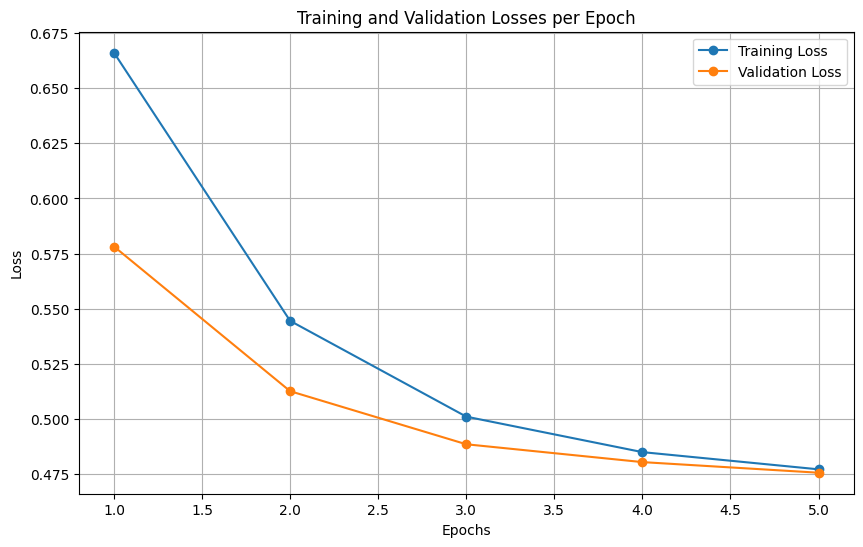

Test Loss: 0.4873
Test Accuracy (Exact Match): 0.0067
Test Accuracy (At Least One Match): 0.0000


('fine_tuned_bert_model\\tokenizer_config.json',
 'fine_tuned_bert_model\\special_tokens_map.json',
 'fine_tuned_bert_model\\vocab.txt',
 'fine_tuned_bert_model\\added_tokens.json')

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import json
import numpy as np
import matplotlib.pyplot as plt
import random

# Setup GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets with sampling
#I'm using only 10% of the dataset because my Laptop is unable to handle the larger amount data and trainig the model
#I hope you understand the scenario
# 0.10 refers to 10% of data is used
def load_data(filepath, sample_fraction=0.10): 
    with open(filepath, 'r') as file:
        lines = file.readlines()
        sampled_lines = random.sample(lines, int(len(lines) * sample_fraction))
        data = [json.loads(line) for line in sampled_lines]
    return data
'''
# Load datasets without sampling
def load_data(filepath): 
    with open(filepath, 'r') as file:
        data = [json.loads(line) for line in file]
    return data
'''

train_data = load_data(r'D:\Data Mining\Programming Assignment - 3\Data Files\student_5\train.json')
val_data = load_data(r'D:\Data Mining\Programming Assignment - 3\Data Files\student_5\validation.json')
test_data = load_data(r'D:\Data Mining\Programming Assignment - 3\Data Files\student_5\test.json')

# Define dataset class
class TweetDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        tweet = item['Tweet']
        labels = [int(item[key]) for key in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 
                                             'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset and DataLoader
max_len = 256
batch_size = 16

train_dataset = TweetDataset(train_data, tokenizer, max_len)
val_dataset = TweetDataset(val_data, tokenizer, max_len)
test_dataset = TweetDataset(test_data, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11).to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5  # number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store losses for plotting
training_losses = []
validation_losses = []

# Training loop
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    losses = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
    return np.mean(losses)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    losses = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            losses.append(loss.item())

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy() > 0.5)  # Ensure this is also binary

    all_preds = np.vstack(all_preds).astype(int)  # Ensure integer type for bitwise operations
    all_labels = np.vstack(all_labels).astype(int)

    # Compute metrics
    exact_match_accuracy = np.mean((all_preds == all_labels).all(axis=1))
    at_least_one_match_accuracy = np.mean(np.any(np.bitwise_and(all_preds, all_labels), axis=1))  # Using np.bitwise_and

    return np.mean(losses), exact_match_accuracy, at_least_one_match_accuracy

# Fine-tuning the model
for epoch in range(5):
    train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    training_losses.append(train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
    
    val_loss, _, _ = evaluate(model, val_loader, device)
    validation_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Losses per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on the test set
test_loss, exact_match_accuracy, at_least_one_match_accuracy = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy (Exact Match): {exact_match_accuracy:.4f}")
print(f"Test Accuracy (At Least One Match): {at_least_one_match_accuracy:.4f}")

# Save the model and tokenizer
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')